In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.9 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Setup matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# If GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
env = gym.make("CartPole-v1")


In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [5]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [6]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n
state, _ = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0
episode_durations = []


In [7]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    if show_result:
        plt.title('Result!')
    else:
        plt.title('Training...')
    plt.pause(0.001)
    if is_ipython:
        display.display(plt.gcf())
        display.clear_output(wait=True)


Episode 1: Total Reward = 15.0
Episode 2: Total Reward = 16.0
Episode 3: Total Reward = 22.0
Episode 4: Total Reward = 24.0
Episode 5: Total Reward = 10.0
Episode 6: Total Reward = 14.0
Episode 7: Total Reward = 11.0
Episode 8: Total Reward = 11.0
Episode 9: Total Reward = 11.0
Episode 10: Total Reward = 11.0
Episode 11: Total Reward = 20.0
Episode 12: Total Reward = 20.0
Episode 13: Total Reward = 16.0
Episode 14: Total Reward = 27.0
Episode 15: Total Reward = 14.0
Episode 16: Total Reward = 12.0
Episode 17: Total Reward = 41.0
Episode 18: Total Reward = 11.0
Episode 19: Total Reward = 14.0
Episode 20: Total Reward = 19.0
Episode 21: Total Reward = 17.0
Episode 22: Total Reward = 17.0
Episode 23: Total Reward = 16.0
Episode 24: Total Reward = 10.0
Episode 25: Total Reward = 15.0
Episode 26: Total Reward = 14.0
Episode 27: Total Reward = 22.0
Episode 28: Total Reward = 11.0
Episode 29: Total Reward = 24.0
Episode 30: Total Reward = 18.0
Episode 31: Total Reward = 20.0
Episode 32: Total

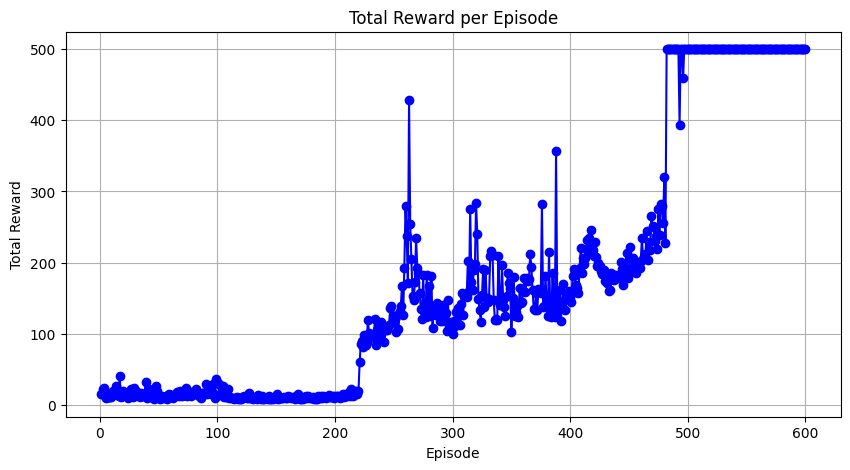

In [14]:

import pygame
import math
import os
episode_durations=[]
episode_rewards = {}
# Initialize Pygame
pygame.init()
screen_width, screen_height = 640, 480
screen = pygame.display.set_mode((screen_width, screen_height))

def draw_pendulum(state):
    # Calculate pendulum position for visualization
    angle = state[0]  # Assuming the first index of state is the angle
    length = 200  # Length of the pendulum
    x = int(screen_width / 2 + length * math.sin(angle))
    y = int(screen_height / 2 + length * math.cos(angle))

    # Draw elements
    screen.fill((0, 0, 0))  # Clear screen
    pygame.draw.line(screen, (255, 255, 255), (screen_width // 2, screen_height // 2), (x, y), 5)
    pygame.draw.circle(screen, (0, 128, 255), (x, y), 20)
    pygame.display.flip()

num_episodes = 600 if torch.cuda.is_available() else 60

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    cumulative_reward = 0  # Initialize cumulative reward
    for t in count():
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()

        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        draw_pendulum(observation)
        reward = torch.tensor([reward], device=device)
        cumulative_reward += reward.item()  # Update cumulative reward
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_rewards[i_episode + 1] = cumulative_reward  # Store episode reward in the dictionary
            print(f'Episode {i_episode + 1}: Total Reward = {cumulative_reward}')  # Print total reward
            break

print('Complete')

# Example of how to plot episode rewards if desired
plt.figure(figsize=(10, 5))
plt.plot(list(episode_rewards.keys()), list(episode_rewards.values()), marker='o', linestyle='-', color='b')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.grid(True)
plt.show()